In [3]:
%matplotlib inline
import pylab as plt
import seaborn as snb
import numpy as np

import networkx as nx

from tqdm import tqdm
import numpy.matlib
from scipy.special import betaln
from scipy.special import gammaln
from scipy import stats

from collections import Counter

from exercise12 import load_karate
from exercise12 import compute_node_and_link_counts

snb.set_style('darkgrid')
snb.set(font_scale=1.5)

# 02477 Bayesian Machine Learning - Exercise 12

In this exercise we will work with Bayesian models for network and relationel data. We will model an undirected graph representing interactions between members of a Karate club. 


- Part 1: Load and visualization of the Zachary’s Karate Club dataset


- Part 2: The Erdős-Rényi model
    - A: Computing the posterior distribution
    - B: Posterior predictive checking
    
    
    
- Part 3: Fitting the infinite relational model
    - A: Computing the posterior distribution
    - B: Posterior predictive checking
    - C: Visualizing the estimated partitions
    
    
Note: You need to install the package **networkx** to plot the graph for the Karate club network.
    

### Part 1: Loading, visualizing and computing simple network statistics of the Zachary’s Karate Club dataset

We will be working with the dataset called ''Zachary’s Karate Club dataset'', which is a well-known dataset in network science (https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We model the karate club as an undirected graph with 34 vertices/nodes and 78 edges/links. Each node corresponds to a member of the club and a link between member $i$ and member $j$ means that these two moments interacted outside the club. 

Due to a conflict in the club, the club was roughly split in half. In this exercise, we will investigate if we can detect this from the graph of the interactions. 

First, we will load and visualize the data set.

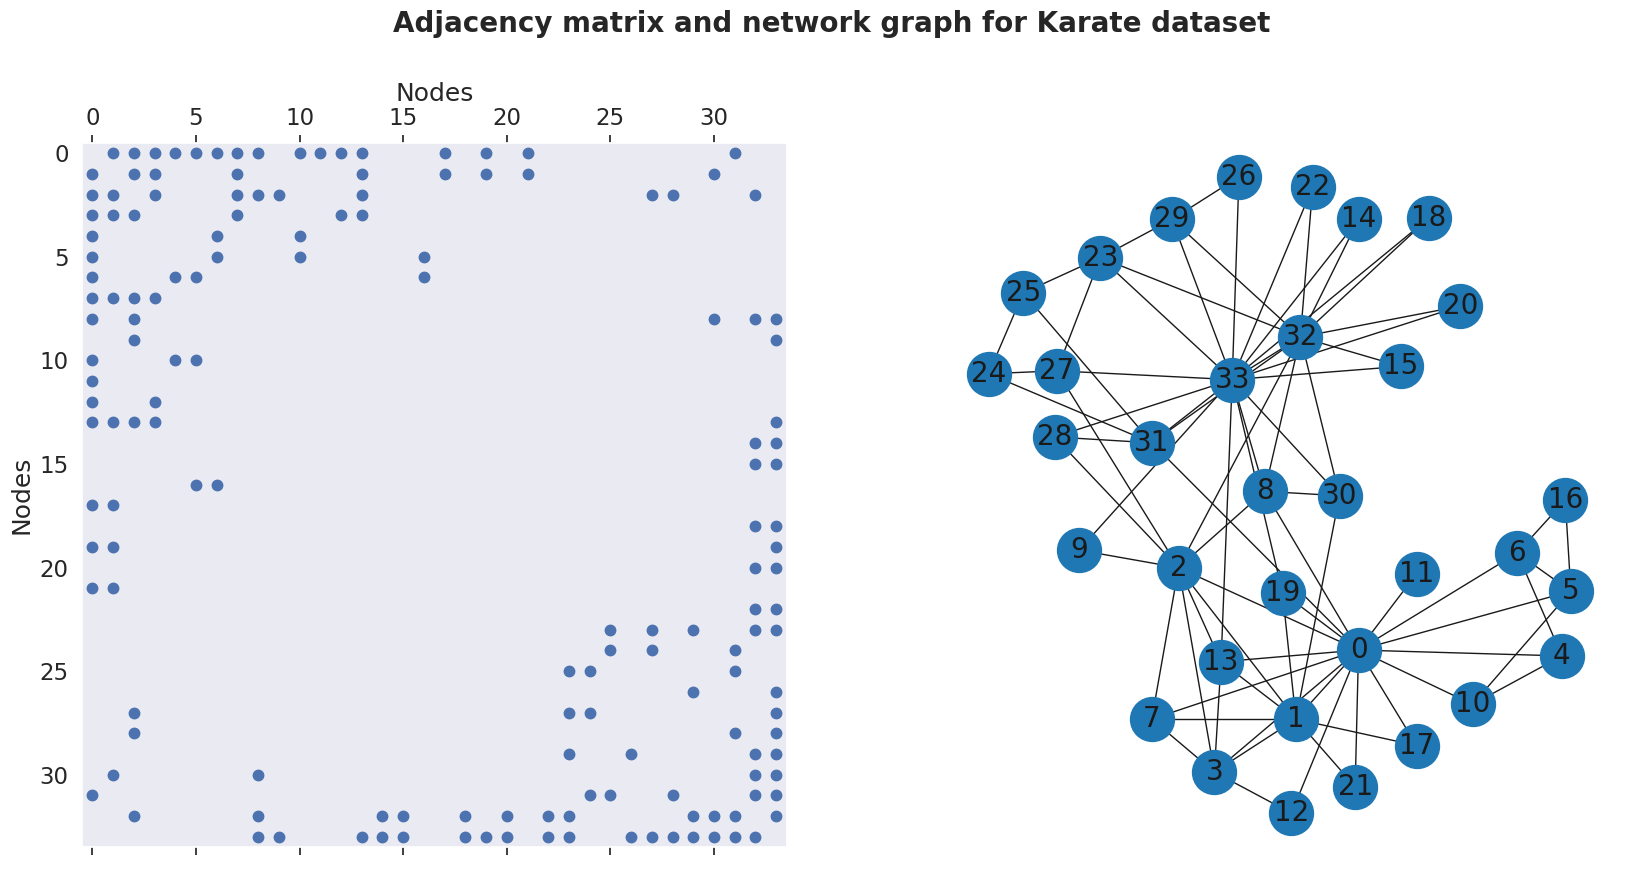

In [4]:
# load data
X, N, edges, coords = load_karate()

# prep figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# plot adjacency matrix
axes[0].spy(X, marker='.', markersize=15)
axes[0].grid(False)
axes[0].set_ylabel('Nodes');
axes[0].xaxis.set_label_position('top') 
axes[0].set_xlabel('Nodes')

# plot graph
nx.draw(nx.from_numpy_array(X), pos=coords, with_labels=True, node_size=1000, font_size=20)
fig.suptitle('Adjacency matrix and network graph for Karate dataset', fontweight='bold', fontsize=20);

**Questions**

1) What is the interpretation of the  adjacency matrix?  What is the relationship between each dot in the adjacency matrix and the graph to the right?
* The adjacency matrix shows which nodes are connected with a link. A dot means that the row node id is connected with the column node id.
* The graph to the right visualizes the links i.e. the dots in the adjacency matrix

1) Why is the adjacency matrix symmetric?
* Because the graph is undirected i.e. if 0 is connected to 10 then 10 is also connected to 0
* If the graph was directed then there could be a link going from 0 to 10 but not from 10 to 0 e.g. if 0 like 10 but 10 does not like 0.

Next, we investigate simple network statistics based on the **degree** of each node of the network. The degree for the $i$'th node is defined as

\begin{align*}
    \text{degree}(i) = \sum_{j=1}^N X_{ij} \tag{1}
\end{align*}


**Task 1**: 

1. Compute the degree for each node in the network using eq. (1) and make a histogram of the node degrees.

2.  Compute mean degree and the maximum degree for the network.


**Questions**

1) Explain in your own words how the **degree** of a vertex/node is defined.
* The degree of a node is the number of links of a node.
  * For a directed graph the degree can be defined as the out degree, links going from the node to other nodes, or in degree, links going from other nodes to the current node, or combined as the total degree/degree
  * For an undirected graph the in and out degree of a node is the same, since there is not direction on the graph edges. 

1) Does all members of the club appear to have roughly the same degree?
* No, the median degree is 6 i.e. the most common. However, the mean degree is 10.5 and this is because some nodes are taking many more connections which is also seen from the maximum node degree which is 33. These nodes with high degrees are probably some respected people in the karate community with good connections e.g. grand masters or social people.

Avg. degree: 4.6
Max. degree: 17


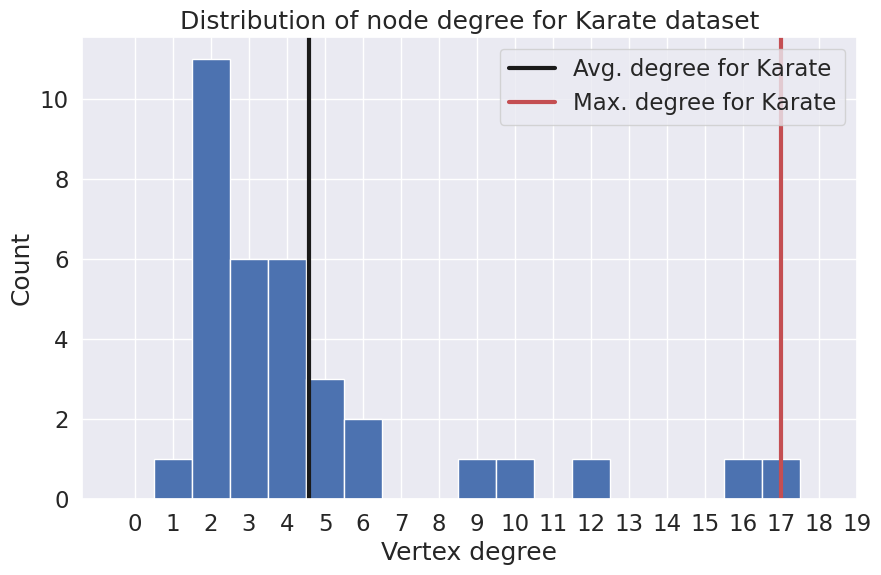

In [15]:
# 1.1 Degree of each node
degree = np.sum(X, 1)
avg_degree = np.mean(degree);
max_degree = np.max(degree);

# visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bins = np.arange(0, degree.max() + 1.5) - 0.5
ax.hist(degree, bins);
ax.set_xlabel('Vertex degree');
ax.set_xticks(np.arange(0, 20, 1));
ax.set_xticklabels(np.arange(0, 20, 1));
ax.axvline(avg_degree, label='Avg. degree for Karate', color='k', linewidth=3)
ax.axvline(max_degree, label='Max. degree for Karate', color='r', linewidth=3)
ax.legend();
ax.set_title('Distribution of node degree for Karate dataset')
ax.set_ylabel('Count')

print('Avg. degree: %2.1f' % avg_degree)
print('Max. degree: %d' % max_degree)

In [19]:
# 1.2 Mean and maximum degree of network
print(f"Mean degree: {np.mean(degree)}")

print(f"Median degree: {np.median(degree)}")

print(f"Maximum degree: {np.max(degree)}")

Mean degree: 4.588235294117647
Median degree: 3.0
Maximum degree: 17.0


### Part 2a: Fitting the Erdős-Rényi model to the dataset

In this part, we will fit the simple **Erdős-Rényi model** for random graphs to the Karate dataset. This model assumes that each edge of the graph can be described by a Bernoulli random variable with a common edge-probability $\phi \in 
\left[0, 1\right]$ such that
\begin{align*}
X_{ij}|\phi \sim \text{Ber}(\phi) \tag{2},
\end{align*}

where $X_{ij}$ is element $(i,j)$  in the adjacency matrix $\mathbf{X}$.

The likelihood for the model becomes
\begin{align*}
P(\mathbf{X}|\phi) = \prod_{(i,j)} \left(1-\phi\right)^{1-X_{ij}}\phi^{X_{ij}} = \left(1-\phi\right)^{\bar{m}}\phi^{m} \tag{3},
\end{align*}


where the product is taken over all edges $(i,j)$ and where the **summary statistics** $m$ and $\bar{m}$ denote the number of edges and non-edges, respectively. To complete our Bayesian model, we impose a uniform $\text{Beta}(1,1)$-prior for the parameter $\phi$
\begin{align*}
p(\phi) =\text{Beta}(\phi|a,b) \tag{4},
\end{align*}

where $a =1$ and $b=1$.


This model is an instance of the *conjugate* Beta-binomial model, which we studied back in week 1. Therefore, we know that the posterior distribution of $\phi$ given $\mathbf{X}$ is the following Beta distribution


\begin{align*}
\phi | \mathbf{X} \sim \text{Beta}(m + a, \bar{m} + b) \tag{5}.
\end{align*}


**Task 2**

1) Compute the parameters for the posterior distribution of $\phi$

2) Compute and plot the prior and posterior density for $\phi$

3) Compute the posterior mean for $\phi$.

**Solution**

Posterior mean: 0.14


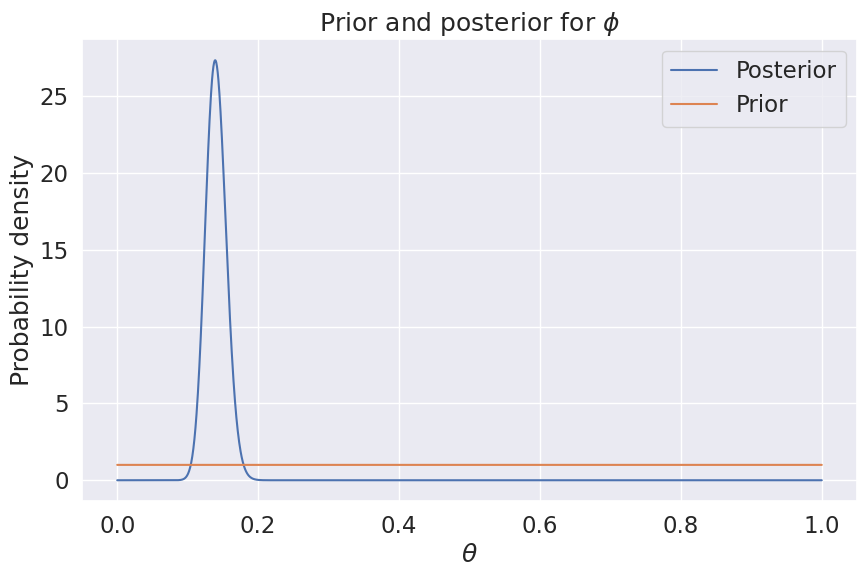

In [9]:
# count edges (m) and non-edges (mbar)
m = np.sum(X)/2
mbar = N*(N-1)/2 - m

### Solution task 2 ###

a = 1
b = 1
a_post = m+a
b_post = mbar+a

t = np.linspace(0,1,2000);
prior_pdf = stats.beta.pdf(t,a,b)
posterior_pdf = stats.beta.pdf(t,a_post, b_post)

# compute posterior mean
post_mean = a_post/(a_post+b_post)
print('Posterior mean: %3.2f' % post_mean)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(t, posterior_pdf, label='Posterior');
ax.plot(t, prior_pdf, label='Prior');
ax.set_xlabel('$\\theta$');
ax.set_ylabel('Probability density');
ax.legend()
ax.set_title('Prior and posterior for $\phi$');

### Part 2b: Posterior predictive checking for the Erdős-Rényi model 

After computing the posterior distribution, the goal of this part is to do **posterior predictive checking** for the Erdős-Rényi model. Posterior predictive checking can be extemely useful for validating models and for identifying potential systematic discrepancies between the model and the data (model misspecification). The posterior predictive distribution for a potential edge/link $\tilde{X}_{ij}$ is more formally given by

\begin{align*}
p(\tilde{X}_{ij}|\mathbf{X}) = \int p(\tilde{X}_{ij}|\phi)p(\phi|\mathbf{X})\text{d} \phi \tag{6}
\end{align*}


We will use the following sampling-based procedure:

1. Generate a set of samples from the posterior distribution $\phi^s \sim p(\phi|\mathbf{X})$ for $s=1, .., S$, where $S$ is the number of samples. 


2. For each sample, $\phi^s$, generate a sample for each potential edge in the network, i.e. $\tilde{X}_{ij}^s | \phi^s \sim \text{Ber}(\phi^s)$. This will generate an adjacency matrix (or graph) $\tilde{\mathbf{X}}^s$ for each posterior sample $\phi^s$. However, note that the samples will not be symmetric.


3. Compute the degrees and the network statistics for each of the posterior predictive samples $\tilde{\mathbf{X}}^s$.


4. Compare the **posterior predictive distribution** of the network statistics with the **observed statistics** based on the Karate club network.


Step 1+2 above will generate samples from the posterior distribution $p(\tilde{X}_{ij}|\mathbf{X})$ and in step 3, we compute the posterior distribution of the statistics of interest.


***Task 3***: Below you are given a code template for generating samples for the posterior predictive checking. Complete the implementation.


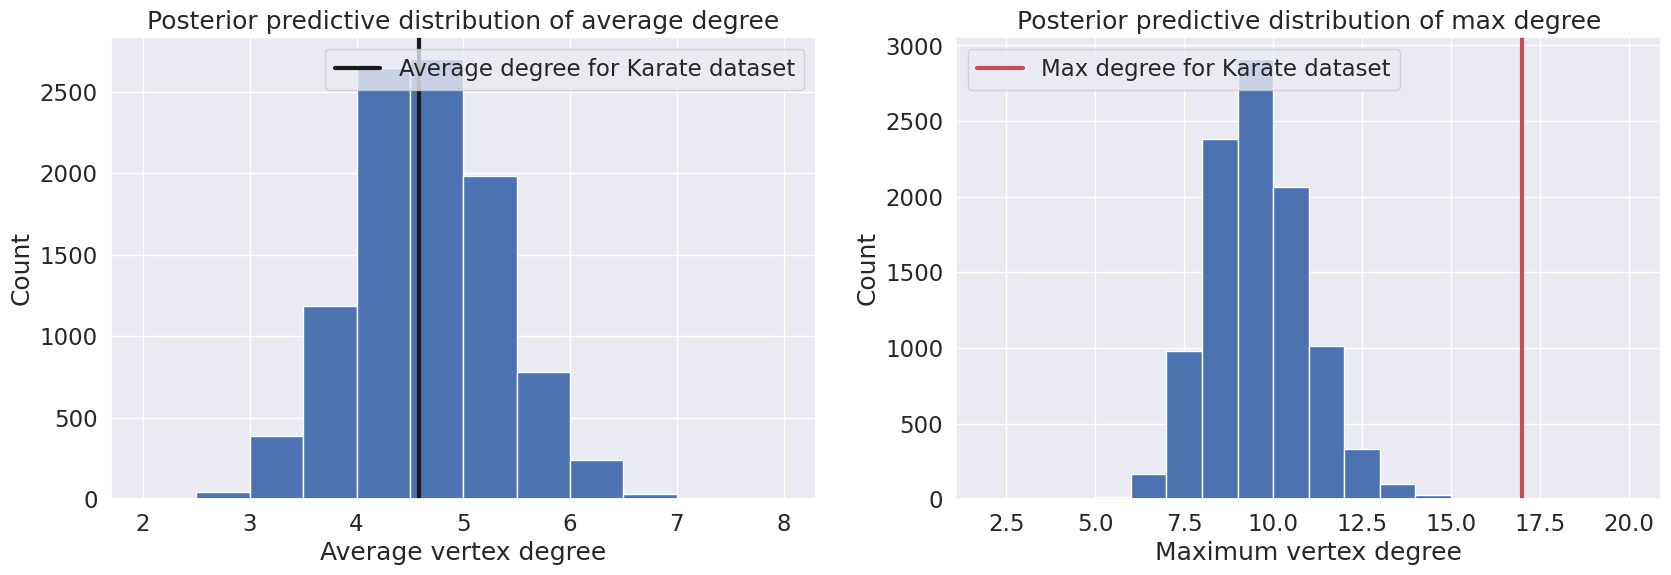

In [20]:
### Solution to task 3 ### 
num_samples = 10000

posterior_avg_degree = np.zeros(num_samples);
posterior_max_degree = np.zeros(num_samples)
for t in range(num_samples):
    
    # sample posterior
    phi = np.random.beta(a_post, b_post)
    
    # sample network given posterior phi
    Xtilde = np.random.binomial(1, phi, size=(N,N))

    # enforce symmetry with zero diagonal
    Xtilde = np.triu(Xtilde, 1)+np.triu(Xtilde, 1).T
    
    # compute network statistics
    degree = np.sum(Xtilde, 1)
    posterior_avg_degree[t] = np.mean(degree)
    posterior_max_degree[t] = np.max(degree)


# plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

axes[0].hist(posterior_avg_degree, np.linspace(2, 8, 13));
axes[0].axvline(avg_degree, linewidth=3, color='k', label='Average degree for Karate dataset')
axes[0].set_xlabel('Average vertex degree');
axes[0].set_ylabel('Count')
axes[0].set_title('Posterior predictive distribution of average degree')
axes[0].legend()

axes[1].hist(posterior_max_degree, np.arange(2, 21));
axes[1].axvline(max_degree, linewidth=3, color='r', label='Max degree for Karate dataset')
axes[1].set_xlabel('Maximum vertex degree');
axes[1].set_ylabel('Count')
axes[1].set_title('Posterior predictive distribution of max degree')
axes[1].legend();

**Question**

1) How well does the posterior predictive distribition of the statistics from the simulated data match with the statistics from the actual dataset?
* It matches the mean statistics of the actual dataset, but not the maximum degree
* This is an issue, since the simulated data then does not capture the clustering of nodes in the network
* We can't capture the power law in the network where few nodes have many edges and most have fewer edges

### Part 3a: The infinite relational model (IRM)

Next, we will fit the **infinite relational model**  to the Karate dataset. The model assumes that the vertices of the graph can be partitioned into a set of clusters, where $z_i$ indicates the cluster assignment for the $i$'th node. The model further assumes that the probability of observing a link from cluster $k$ to cluster $\ell$ is $\phi_{k, \ell} \in \left[0, 1\right]$. Therefore, the likelihood becomes


\begin{align*}
    X_{ij}|\phi, \mathbf{z} &\sim \text{Ber}(\phi_{z_i, z_j}),
\end{align*}


where $z_i$ and $z_j$ are the cluster assignments for the $i$'th and $j$'th node, respectively.

The IRM model can be seen as a **non-parametric** extension of the **stochastic block model** (SBM).
In the SBM model, the number of clusters is $K$, where $K$ is treated as a hyperparameter. Therefore, in the SBM model, the cluster assignments are modelled using a $K$-dimensional Categorical distribution $z_n|\pi \sim \text{Cat}(\pi)$ with Dirichlet prior on the cluster probabilitites, i.e. $\pi \sim \text{Dir}(\alpha)$,  similar to Bayesian formulation to the Gaussian mixture model, which we studied in Exercise 9.

Informally, the IRM model can be obtained from the SBM model by marginalizing over the cluster probabilitites and then taking the limit of $K \rightarrow \infty$. Thus, informally, the IRM model is a stochastic block model, where we potentially allow an infinite number of clusters. The resulting prior on the partition $\mathbf{z}$ is called the **Chinese restaurant process** (CRP) and is controlled by a single hyperparameter $A$.

The IRM is given by


\begin{align*}
    \mathbf{z} &\sim \text{CRP}(A)\\
    \phi_{k, \ell} &\sim \text{Beta}(a, b)\\
    X_{ij}|\phi, \mathbf{z} &\sim \text{Ber}(\phi_{z_i, z_j}),
\end{align*}


where $\phi_{k, \ell} \in \left[0, 1\right]$ is the probability of observing a link between cluster $k$ and cluster $\ell$. The CRP prior is given by


\begin{align*}
    p(\mathbf{z}) = \frac{\Gamma (A) A^{\bar{K}} }{\Gamma(A + N)} \prod_{k=1}^{\bar{K}} \Gamma(n_k)\tag{7},
\end{align*}


where $\bar{K}$ denotes the number of non-empty clusters, $n_k$ denodes the number of nodes assigned to the $k$'th non-empty cluster and $\Gamma(\cdot)$ is the gamma function (which we haven't discussed in detail in this course).


In practice, we often treat the $\phi_{k\ell}$-parameters as a **nuisance**-parameters and marginalize them out:

\begin{align*}
p(\mathbf{X}|\mathbf{z}) = \int p(\mathbf{X}|\mathbf{z}, \boldsymbol{\phi})p(\boldsymbol{\phi})\text{d}\boldsymbol{\phi} = \prod_{(k,l)} \frac{B(m_{k,l} + a, \bar{m}_{k,l}+b)}{B(a,b)}\tag{8},
\end{align*}
where $m_{k,l}$ and $\bar{m}_{k,l}$ denote the number of links and non-links, respectively, between clusters $k$ and $j$ and re $B(a,b)=\frac{\Gamma (a) \Gamma (b)}{\Gamma (a+b)}$ is the beta-function (i.e. normalization constant from the Beta distribution). Note that we only include each edge once in the product over $(k,l)$, i.e. if $(1,2)$ is included, we do not include $(2,1)$ since that we include all edges twice.



Thus, our goal is to compute the posterior distribution $p(\mathbf{z}|\mathbf{X}) \propto p(\mathbf{X}|\mathbf{z})p(\mathbf{z})$. Since the posterior is intractable, we will use *Gibbs sampling* to compute the posterior distribution.

In Gibbs sampling, we iteratively sample from the **complete posterior conditional distributions** $p(z_n|\mathbf{X}, \mathbf{z}_{-n})$, where $\mathbf{z}_{-n}$ contains the cluster assignment for all nodes except for the $n$'th node. Despite the infinite nature of the model, these distributions can be readily derived analytically and depends on the counts of links and non-links between each of the non-empty clusters. We won't go into the specific derivations or expressions, but we will rather focus on understanding the model and what we can do with it.



The function *irm_gibbs* below implements a Gibbs sampler for the IRM model. In the function *compute_node_and_link_counts* we make extensive use of the fact that we can count

- *m*: the number of nodes in each cluster/component
- *M*: the number of link between each pair of clusters/components
- *Mbar*: the number of non-link between each pair of clusters/components

using simple matrix operations on $\mathbf{X}$ and $\mathbf{z}$.

Let's run the sampler for 2000 iterations and discard the first half as warm-up samples. We wil assume uniform priors for each edge probability and set $a = 1$ and $b=1$. For the concentration parameter $A$, we will use a heuristic and set $A = \log(N)$.

*Note: you may get a warning because in some iteration we end up taking the log(0), but this can safely be ignored*

In [21]:
def all_indices_except_n(N, n):
    """ generates a list of indices from [0, 1, .., N-1], where index n has been removed """
    nn = list(range(N))
    nn.remove(n)
    return nn


def irm_gibbs(X, a, b, A, max_itt=1000, warmup_fraction=0.5, seed=0):
    
    np.random.seed(seed)
    N = len(X)
    warmup = int(warmup_fraction*max_itt)
    
    # Initialize
    z = np.ones((N, 1))
    Z = []

    for t in range(max_itt):
        
        # sample from p(z_n|X, z_{-n}) for each n = 1, 2, ..., N
        for n in range(N):

            # Get all indices except for the n'th node        
            nn = all_indices_except_n(N, n)   
            Xnn = X[nn, :][:, nn]
            znn = z[nn]

            # Current number of components in current partition
            K = z.shape[1]                                                    

            # Computes the number (m) of nodes and the number of links (M) between each pair of components
            m, M, Mbar = compute_node_and_link_counts(Xnn, znn)
            
            # Compute number of links from node n    
            r = znn.T@X[nn,n]

            # Log probability of node n belonging to an existing or a new component
            log_P = np.sum(np.row_stack((betaln(M+r+a,Mbar+m-r+b)-betaln(M+a,Mbar+b), betaln(r+a,m-r+b)-betaln(a,b))), axis=1) + np.log(np.hstack((m, A)))
        

            # Sample new assignment for node n according to P
            P = np.exp(log_P-np.max(log_P));
            P = P/np.sum(P)
            i = np.random.choice(range(len(P)), p=P)

            # Update assignment for node n        
            z[n,:] = 0 
            if i < K:     # assign to existing cluster
                z[n,i] = 1; 
            else:         # assign to new cluster   
                z = np.column_stack((z, np.zeros(N)))
                z[n,i] = 1; 

            # Remove empty clusters   
            z = z[:, np.sum(z, axis=0) > 0]

        # store current sample        
        Z.append(np.array(z))

        
    return Z[warmup:]

# hyperparameters
a = 1
b = 1
A = np.log(len(X))
Z = irm_gibbs(X, a, b, A, max_itt=2000, warmup_fraction=0.5)


/tmp/ipykernel_349/2064799731.py:38: RuntimeWarning: divide by zero encountered in log
  log_P = np.sum(np.row_stack((betaln(M+r+a,Mbar+m-r+b)-betaln(M+a,Mbar+b), betaln(r+a,m-r+b)-betaln(a,b))), axis=1) + np.log(np.hstack((m, A)))


**Questions**

1) What makes it possible to represent a model with a potentially infintite number of components in pratice?
   * That the number of non-empty components, which is what we care about, are limited by the number of nodes

2) Explain the prior of $\mathbf{z}$ using the Chinese restaurant metaphor in your own words. What does the value of $A$ represent in the CRP metaphor?
* A controls the rate at which new clusters are created i.e. large A means more new clusters and smaller A means less new clusters


3) Why do we need to discard the first half of the samples as warm-up?
* Because the Gibbs sampling has to converge first. We sample step wise for each parameter while conditioning on the rest, this takes some time to converge


4) Inspect a few samples in the list $Z$ and make sure you understand how the partitions are represented.
* They are represented as a one-hot encoded vector where a 1 reprensents the assigned cluster for a given node

### Posterior distribution on the number of clusters

Let's calculate the number of non-empty clusters, and plot the trace and posterior distribution.

Posterior mean for K:		6.42
Posterior median for K:		  6


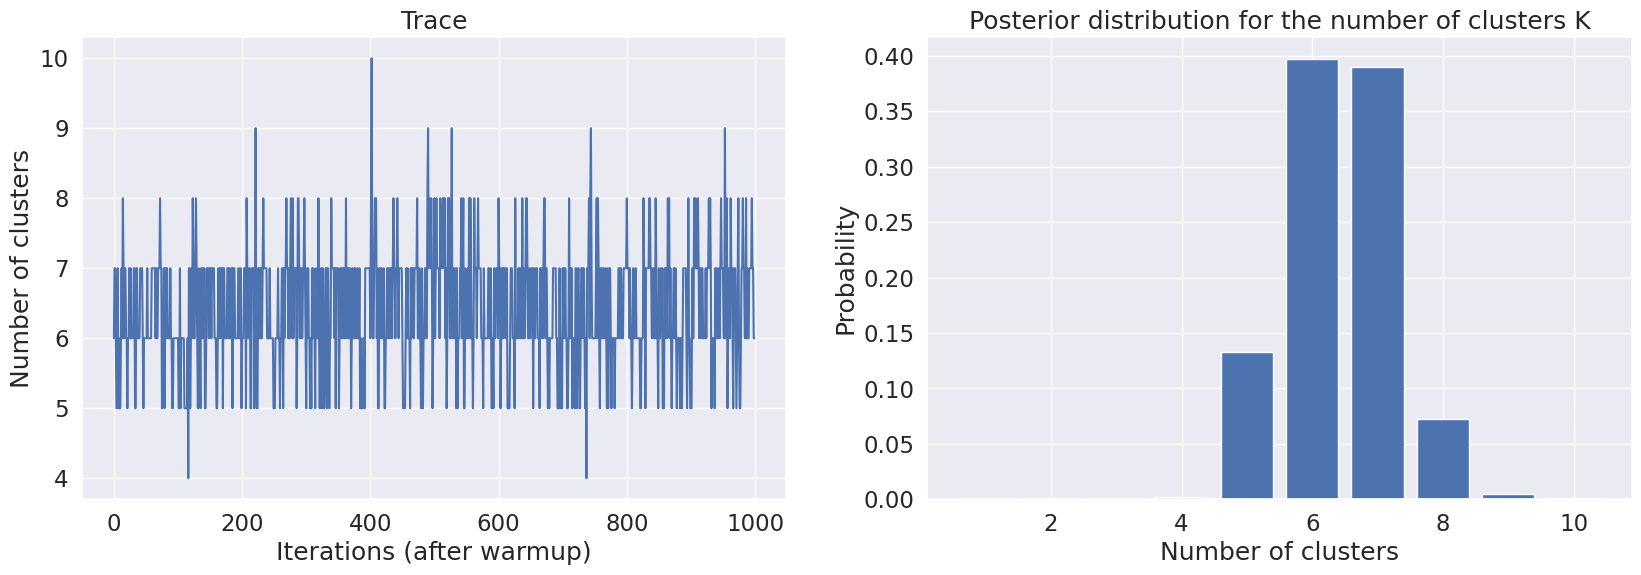

In [25]:
# compute number of clusters for each sample
K_samples = np.array([zi.shape[1] for zi in Z])

# compute posterior probabilities over the number of clusters
K_values = np.arange(1, np.max(K_samples)+1)
counts = np.array([np.sum(K_samples==j) for j in K_values])
p = counts/np.sum(counts)

print('Posterior mean for K:\t\t%3.2f' % np.mean(K_samples))
print('Posterior median for K:\t\t%3d' % np.median(K_samples))

# plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(K_samples)
axes[0].set_xlabel('Iterations (after warmup)')
axes[0].set_ylabel('Number of clusters')
axes[0].set_title('Trace')

axes[1].bar(K_values, p)
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Probability');
axes[1].set_title('Posterior distribution for the number of clusters K');

**Questions**

1) Explain what you see in the figures. Summarize your knowledge about the number of clusters in the network based on the posterior distribution.
* In the left figure we see a convergence of the number of non-empty clusters going in the interval 5 to 8
* The right plot shows the actual posterior distribution of the number of clusters that we can expect to get. The most likely being around 6 or 7

2) Does the MCMC chain appear to have converged?
* Yes, it looks like convergence with a mean around 6 or 7


**Task 4**: What is the posterior probability that the number of clusters $K$ is between $5 < K < 8$? What about between $5 \leq K \leq 8$?

*Hint*: What is the fraction of posterior samples, where $K$ is in this range?



In [41]:
np.mean((K_samples > 5) & (K_samples < 8))

0.787

In [43]:
np.mean((5 <= K_samples) & (K_samples <= 8))

0.992

### Part 3b: Posterior predictive checking for the IRM model

After having obtained a representation of the posterior distribution $p(\mathbf{z}|\mathbf{X})$, we repeat same procedure for posterior predictive checking as we did for the Erdős-Rényi model. 


The Gibbs sampler above was set-up to generate samples from $p(\mathbf{z}|\mathbf{X})$. In order to sample from the posterior predictive distribution, we need to express it as an expectation wrt. $p(\mathbf{z}|\mathbf{X})$:

\begin{align*}
p(\tilde{\mathbf{X}}|\mathbf{X}) &\stackrel{(a)}{=} \int \sum_{\mathbf{z}} p(\tilde{\mathbf{X}}|\mathbf{z}, \phi) p(\phi, \mathbf{z}|\mathbf{X})\text{d} \phi\\
%
&\stackrel{(b)}{=} \sum_{\mathbf{z}} \int p(\tilde{\mathbf{X}}|\mathbf{z}, \phi) p(\phi|\mathbf{z}, \mathbf{X})p(\mathbf{z}| \mathbf{X})\text{d} \phi\\
%
&\stackrel{(c)}{=} \sum_{\mathbf{z}} \int p(\tilde{\mathbf{X}}|\mathbf{z}, \phi) p(\phi|\mathbf{z}, \mathbf{X})\text{d} \phi p(\mathbf{z}| \mathbf{X})\\
%
&\stackrel{(d)}{\approx} \frac{1}{S}\sum_{s=1}^S \int p(\tilde{\mathbf{X}}|\mathbf{z}^s, \phi) p(\phi|\mathbf{z}^s, \mathbf{X})\text{d} \phi, \\
\end{align*}



where $\mathbf{z}^s$ denotes the $s$'th posterior sample from our Gibbs sampler and $p(\phi_{k\ell}|\mathbf{z}, \mathbf{X}) = \text{Beta}(\phi_{k\ell}|a + M_{k\ell}, b + \bar{M}_{k\ell})$. 

**Question**: 
- In the calculation above, we made use of the following "tricks":

1) Monte Carlo sampling
* (d)
2) the product rule 
   * (b)
3) the sum rule
   * (a)

4) the fact that $p(\mathbf{z}| \mathbf{X})$ does not depend on $\phi$. 
   * (c)

Can you match the four "tricks" to the four steps in the equation above (i.e.  (a), (b), (c) and (d))?





Thus, for each posterior sample of $\mathbf{z}^s$, 

1. we generate a sample for $\phi^s_{k\ell}|\mathbf{z}^s \sim \text{Beta}(a + M^s_{k\ell}, b + \bar{M}^s_{k\ell}$) for all pairs $(k, \ell)$.

2. we sample values for all potential links in the graph given the current assignment $\mathbf{z}^s$ and $\phi^s_{k, \ell}$ using $X_{ij}|\mathbf{z}^s, \phi^s \sim \text{Ber}(\phi^s_{z^s_i, z^s_j})$. 


The function **irm_posterior_predictive** implements this and generates an adjacency matrix $\tilde{\mathbf{X}}$ for a posterior sample $\mathbf{z}^s$.



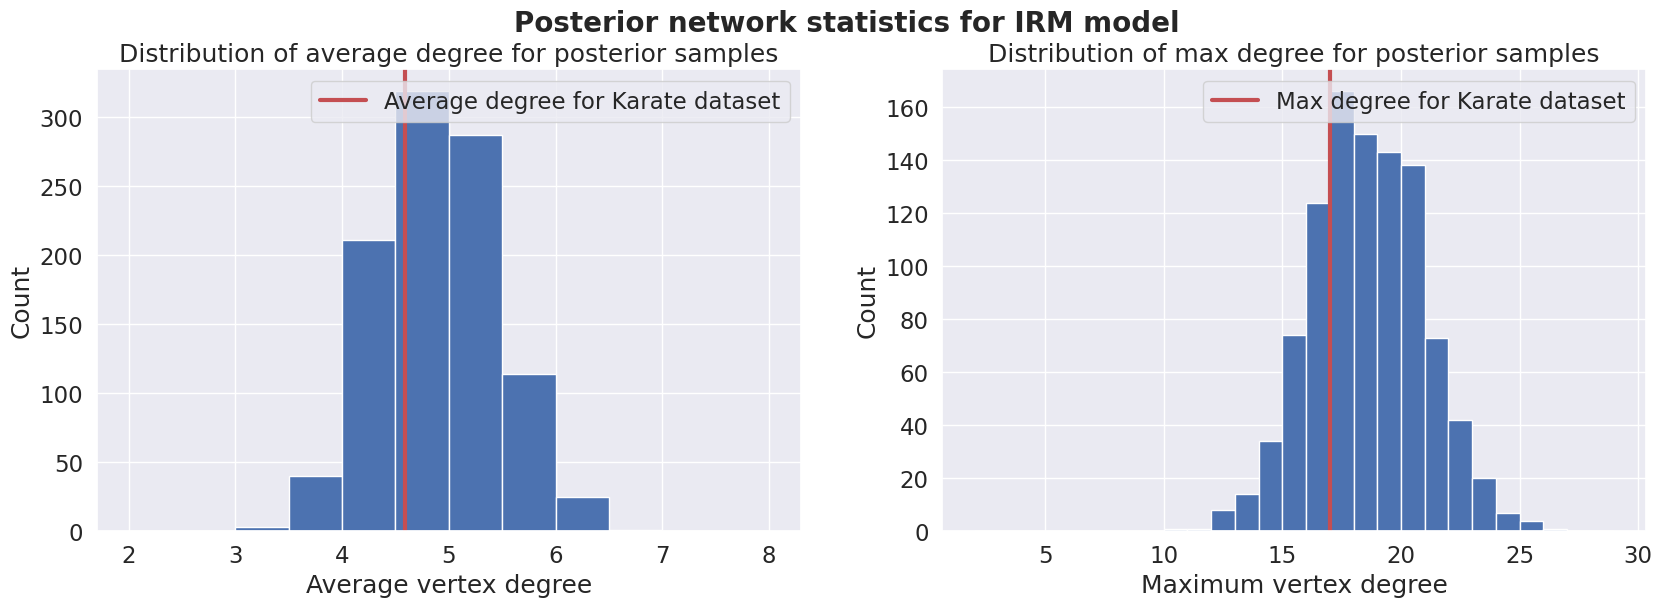

In [44]:
def irm_posterior_predictive(X, z, a, b):
    
    # Compute number of nodes (m) and number of links (M, Mbar) between each component
    m, M, Mbar = compute_node_and_link_counts(X, z)
    
    # Step 1: sample phi from p(phi|X, z) and make it symmetric
    phi = np.random.beta(M+a, Mbar+b)
    phi = np.triu(phi)+np.triu(phi,1).T
    
    # prepare probability for each pair of nodes (this is simply a clever way to extract all the relevant phi-probabilities for each pair of clusters)
    P = z@phi@z.T
    
    # Step 2: Sample adjacency matrix and make it symmetric
    Xtilde = np.random.binomial(1, P)
    Xtilde = np.triu(Xtilde, 1) + np.triu(Xtilde, 1).T

    return Xtilde

# compute network statistics for the posterior predictive distribution
np.random.seed(0)
posterior_avg_degree_irm = np.zeros(len(Z))
posterior_max_degree_irm = np.zeros(len(Z))

for t in range(len(Z)):
    Xtilde = irm_posterior_predictive(X, Z[t], a, b)
    
    degree = np.sum(Xtilde, 1)
    posterior_avg_degree_irm[t] = np.mean(degree)
    posterior_max_degree_irm[t] = np.max(degree)
    

# plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

axes[0].hist(posterior_avg_degree_irm, np.linspace(2, 8, 13));
axes[0].axvline(avg_degree, linewidth=3, color='r', label='Average degree for Karate dataset')
axes[0].set_xlabel('Average vertex degree');
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of average degree for posterior samples')
axes[0].legend()

axes[1].hist(posterior_max_degree_irm, np.arange(2, 30));
axes[1].axvline(max_degree, linewidth=3, color='r', label='Max degree for Karate dataset')
axes[1].set_xlabel('Maximum vertex degree');
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of max degree for posterior samples')
axes[1].legend();
fig.suptitle('Posterior network statistics for IRM model', fontweight='bold', fontsize=20);

**Questions**

1) Comment on the plots above. How well does the IRM model fit the data?
* It fits it well as it both captures the average node degree and maximum node degree well

2) Compare these results with the corresponding results for the Erdős-Rényi model
* The Erdős-Rényi model does not capture the maximum degree

### Part 3c: Visualizing the partitions

The goal of the last part of the exercise is to visualize the partitions obtained from the IRM model. From the Gibbs sampling proceduce, we obtained $S$ posterior samples of $\mathbf{z}^s$ for $s = 1, 2, ..., S$. We will identity for the sample of $\mathbf{z}^s$ with the highest posterior probability among our $S$ samples and then visualize the corresponding partition:

\begin{align}
\mathbf{z}^* = \arg\max\limits_{s} p(\mathbf{z}|\mathbf{X}) \tag{1}
\end{align}

**Questions**

1) Usually, we compute and visualize the posterior mean and standard deviation of our parameters of interest. We cannot easily do this for the samples of the partitions $\mathbf{z}$. Why not?
* 

*hint*: What is the dimensionality of each sample of $\mathbf{z}$?

2) We can identify the sample with highest **posterior** probability, i.e. $p(\mathbf{z}|\mathbf{X})$, by identifying the sampling with highest **joint** probability, i.e. $p(\mathbf{X}, \mathbf{z}) = p(\mathbf{X}| \mathbf{z})p(\mathbf{z})$.  Why?
  *  $p(\mathbf{z}|\mathbf{X}) = \frac{p(\mathbf{X}|\mathbf{z})p(\mathbf{z})}{p(X)}$ since $p(\mathbf{X})$ is a constant then $p(\mathbf{X}|\mathbf{z})p(\mathbf{z})$ is the defining factor


**Task 5**: Complete the implementation of the function below, which evaluates the joint distribution $p(\mathbf{X}, \mathbf{z})$ for hyperparameters $a$, $b$, and $A$ for each sample of $\mathbf{z}$. We will use the function to evaluate the joint probability for all posterior samples.

*hints*: 1) you need to implement eq. (7) and (8) above. 2) the functions *gammaln* and *betaln* will come in handy. 3) when implementing the likelihood, you should only include each edge once, i.e. we only compute the likelihood for the upper or lower triangular matrix of $\mathbf{X}$. 4) do not hesitate to ask for help or look in the solution if you are stuck.

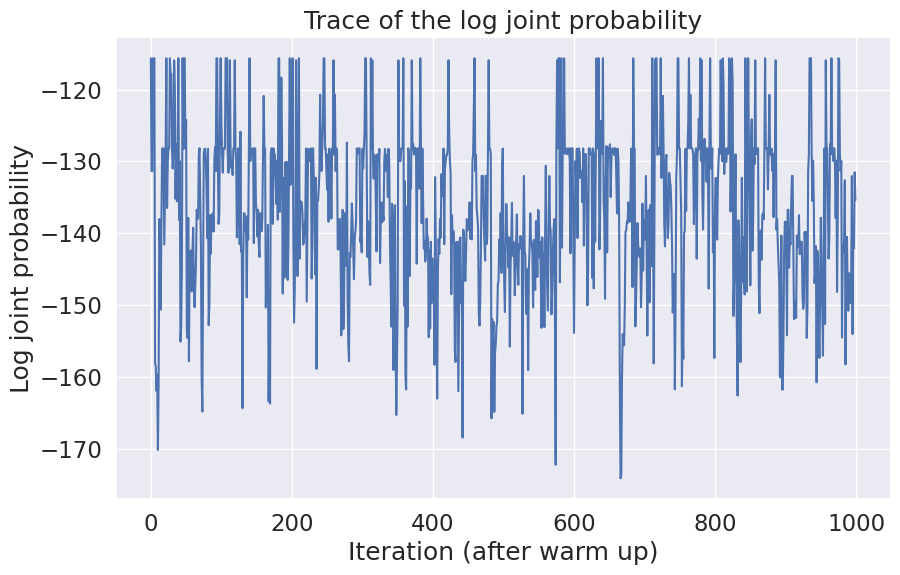

In [45]:
def irm_evaluate_joint(X, Z, a, b, A):

    N = len(X);
    T = len(Z)
    log_lik = np.zeros(T)
    log_prior = np.zeros(T)
    log_joint = np.zeros(T)

    for t in range(T):
        
        # Get clustering
        z = Z[t]
        K = z.shape[1]
        
        # Compute number of nodes (m) in each component and number of links (M, Mbar) between pairs ofcomponent
        m, M, Mbar = compute_node_and_link_counts(X, z)
        
        # prior (eq. (7) above)
        log_prior[t] = K*np.log(A) + gammaln(A) - gammaln(A+N) + np.sum(gammaln(m))
        
        # log likelihood (eq. (8) above). triu is used to extract to upper triangular matrix so each edge is only included once.
        log_lik[t] = np.sum(np.triu(betaln(M+a,Mbar+b)-betaln(a,b), 1))
        
        # joint
        log_joint[t] = log_lik[t] + log_prior[t]
        
    return np.array(log_joint), np.array(log_lik), np.array(log_prior)
    
# compute the joint probability for each sample z in Z
log_joint, log_lik, log_prior = irm_evaluate_joint(X, Z, a, b, A)

# plot trace
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(log_joint)
ax.set_xlabel('Iteration (after warm up)')
ax.set_ylabel('Log joint probability');
ax.set_title('Trace of the log joint probability');

The code below visualizes the clustering for a given posterior sample $\mathbf{z}^s$. The variable **itt** in the first line specifies which sample is visualized.

**Questions**

1) Visualize the clustering for a few different samples and compare. 

2) Identify the partition with the highest posterior probability (among our posterior samples) and visualize it. 

3) Recall that the Karate club was split in half. Do you see that in the clustering?

4) If we go back up and shuffle ordering of the nodes and then repeat the whole analysis. How would that affect the conclusions? You can provide a theoretical argument or test it empirically by adding the following lines of code about loading the data in the beginning of the notebook:

### Visualization

The first plot shows the adjacency matrix $\mathbf{X}$ after the rows and columns have been sorted according to the clustering and the second plot shows the corresponding graph, where each node has been colored according to the clustering.

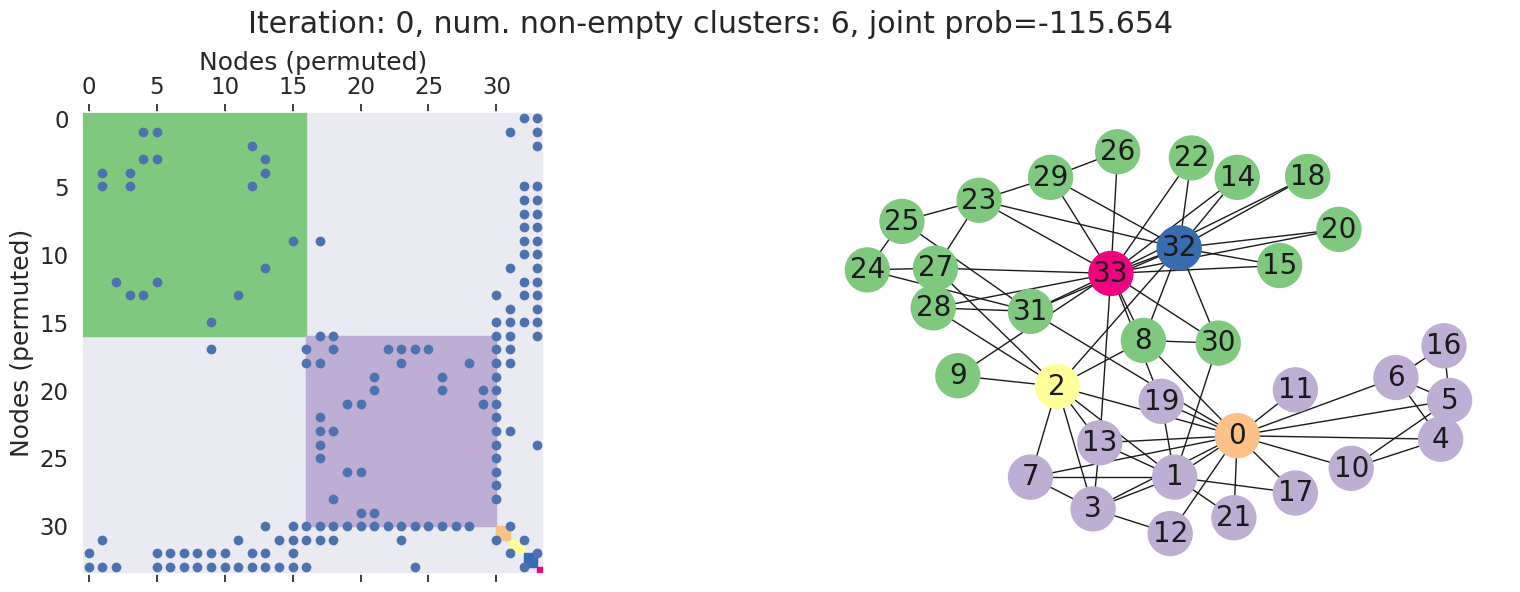

In [46]:
# specify iteration for visualization
itt = np.argmax(log_joint) #len(Z)-1

# get posterior sample for specified iteration
z_itt = Z[itt]

# convert from one-hot representation to integer representation 0, 1, .., K-1 for each node
z_itt_int = np.argmax(z_itt, 1).astype('int')

# get number of non-empty clusters
K = z_itt.shape[1]

# sort by based assigned cluster
sort_idx = np.argsort(z_itt_int)
X_sorted = X[sort_idx, :][:, sort_idx]

# count number nodes in each cluster
count = Counter(z_itt_int[sort_idx])

# plot
colors = np.array(plt.cm.Accent.colors)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# plot adjacency matrix
axes[0].spy(X_sorted, marker='.', markersize=12)
axes[0].grid(False)
axes[0].set_ylabel('Nodes (permuted)');
axes[0].xaxis.set_label_position('top') 
axes[0].set_xlabel('Nodes (permuted)')

# draw clusters partitions on adjacency matrix
last_val = -0.5
for i, x in enumerate(np.cumsum(list(count.values()))):
    size = x - last_val
    axes[0].add_patch(plt.Rectangle((last_val,last_val), size, size, fc=colors[i], ec=colors[i]))
    last_val = x

# draw graph colored by partition
nx.draw(nx.from_numpy_array(X), pos=coords, with_labels=True, node_color=colors[z_itt_int], node_size=1000, font_size=20)

fig.suptitle('Iteration: %d, num. non-empty clusters: %d, joint prob=%4.3f' % (itt, K, log_joint[itt]), y=1.05);
